In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Goals of this notebook

* Build our first classification model and evaluate it on the hold-out sets.

* Try various features and understand what the model is doing.

### Read in data from previous day

In [3]:
DATA_PATH = "../data/walmart"
TRAIN_PATH = f"{DATA_PATH}/train.csv"
TEST_PATH = f"{DATA_PATH}/test.csv"

In [4]:
df_train = pd.read_feather(f'{DATA_PATH}/df_raw_train.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_raw_val.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_raw_test.feather')

### Modeling

The main technique we'll use today is **Logistic Regression**. Logistic regression is *not* a regression model - it is a classification model.

A quick summary:

Given n features - $x_1, x_2, \ldots, x_n$, and a binary target variable - $y \in {0,1}$, logistic regression predicts the probability this example belongs to class 1 as:

$$p = \sigma(w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n)$$

where $\sigma$ is the sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$

As we discussed in the lecture, you can think of $\sigma$ as a softer switch function which "smoothifies" the discrete switch:

$s(x) = 
\begin{cases}
0, \text{ if x < 0} \\
1, \text{ if x} \geq 0
\end{cases}
$

This is a linear model since it uses the linear combination:

$$w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$$

In particular, this means that we don't take into account features like $x_i x_j$ or higher-order terms. If we do want to take those into account, we would have to explicitly create a features (column) $x_i x_j$.

There are other linear classification models. Some examples are:

[TBC]

# Featurization Strategy 1:

We want to predict the trip type of each VisitNumber. Our hypothesis is that one of the simplest predictors is the type of items bought on each trip. But we have several rows for each trip. How can we create a dataset with one row per visit and a description of all the items bought.

The first questions is whether we should use Upc, FinelineNumber or DepartmentDescription to describe what items were bought.

**Question**: What are the tradeoffs between choosing each one of these 3 options?


(DONE) Description -> counts

Description -> normalized counts + Counts column

Description -> normalized counts + Counts column + day of week

The main tradeoff is the number of distinct items. There are 68 unique departments in the train set, 5142 unique FinelineNumbers, and 89281 unique Upc codes. It is initially easier to work at the department level although we should put a marker **TODO** to extend our models with FinelineNo and Upc later.

So how exactly do we create rows that have some description of the departments someone shopped at. The easier way is to have a column for every unique department and a row for each visit number. The entry in row i and column j is the number of items bought during visit i in department j.

**Question**: Can you think of an easy way to create this table using one of the in-build pandas functions we have seen?

In [5]:
pd.pivot_table(df_train, 
               index = 'VisitNumber', 
               columns = 'DepartmentDescription', 
               values = 'ScanCount', 
               aggfunc = 'sum').head(20)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see a bunch of nans in case a visit didn't buy products from a certain department. We should replace these nans by 0. You should also do the same thing with the validation and test datasets.

In [6]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [7]:
df_train_f1.head(2)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


It is always a good idea to check if these numbers are sensible. As a data scientist, it is good to be extremely skeptical of procedures where a lot of data is being transformed into a lot of some other data without fine-grained checks. 

**Question**: Can you think of some checks to do on df_train_f1 and df_train to ensure the correct thing is being done.

In [8]:
visit_number = 7

print(df_train_f1.loc[visit_number].sum())
print(df_train[df_train['VisitNumber']==visit_number]['ScanCount'].sum())

2.0
2


In [9]:
df_train_f1.sum(axis=1).head()

VisitNumber
5     -1.0
7      2.0
8     27.0
9      3.0
10     3.0
dtype: float64

In [10]:
df_train.groupby('VisitNumber').agg({'ScanCount': np.sum}).head()

,ScanCount
VisitNumber,
5,-1
7,2
8,28
9,3
10,3


In [11]:
(df_train_f1.sum(axis=1) - df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']).sum()

-935.0

There is a discrepancy for visit number 8. Let's check why.

In [12]:
df_train[df_train['VisitNumber']==8]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0
6,26,8,Friday,2.006614e+09,1,PAINT AND ACCESSORIES,1017.0
7,26,8,Friday,7.004803e+09,1,PAINT AND ACCESSORIES,2802.0
8,26,8,Friday,2.238495e+09,1,PAINT AND ACCESSORIES,4501.0
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0
10,26,8,Friday,5.200010e+09,1,DSD GROCERY,4606.0
11,26,8,Friday,8.867930e+10,2,PAINT AND ACCESSORIES,3504.0
12,26,8,Friday,2.200600e+10,1,MEAT - FRESH & FROZEN,6009.0


Aha! we can immediately see what causes the discrepancy. We have NaNs in Upc and FinelineNumber. In other words, there are items that weren't classified correctly. Let's see how much of a problem this is.

In [13]:
print(df_train['Upc'].isnull().sum(axis=0))
print(df_train['FinelineNumber'].isnull().sum(axis=0))
print(df_train['DepartmentDescription'].isnull().sum(axis=0))
print(df_train[df_train['DepartmentDescription']==None].shape[0])

3362
3362
1139
0


In [14]:
pd.isnull(df_train['DepartmentDescription'].loc[25])

True

In [15]:
#Understanding if "None" is same as na (it is - see documentation for pd.isnull)
df_train['DepartmentDescription'].head(30).fillna(10)

0           FINANCIAL SERVICES
1                        SHOES
2                PERSONAL CARE
3        PAINT AND ACCESSORIES
4        PAINT AND ACCESSORIES
5        PAINT AND ACCESSORIES
6        PAINT AND ACCESSORIES
7        PAINT AND ACCESSORIES
8        PAINT AND ACCESSORIES
9        PAINT AND ACCESSORIES
10                 DSD GROCERY
11       PAINT AND ACCESSORIES
12       MEAT - FRESH & FROZEN
13       PAINT AND ACCESSORIES
14       PAINT AND ACCESSORIES
15       PAINT AND ACCESSORIES
16       PAINT AND ACCESSORIES
17       PAINT AND ACCESSORIES
18                       DAIRY
19           PETS AND SUPPLIES
20       PAINT AND ACCESSORIES
21    HOUSEHOLD CHEMICALS/SUPP
22       PAINT AND ACCESSORIES
23       PAINT AND ACCESSORIES
24           PETS AND SUPPLIES
25                          10
26         IMPULSE MERCHANDISE
27                     PRODUCE
28                     PRODUCE
29                 DSD GROCERY
Name: DepartmentDescription, dtype: object

We'll fill nulls with the value 0 (for convenience). Let's ensure none of the existing columns have 0s so we don't merge value = 0 with null values

In [16]:
print(0 in df_train['Upc'].unique())
print(0 in df_train['FinelineNumber'].unique())
print(0 in df_train['DepartmentDescription'].unique())

False
True
False


In [17]:
df_train[df_train['FinelineNumber']==0].head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
2082,999,914,Friday,6.053882e+10,1,OTHER DEPARTMENTS,0.0
2401,9,1038,Friday,6.053882e+10,1,OTHER DEPARTMENTS,0.0
3567,999,1415,Friday,6.811317e+10,1,FINANCIAL SERVICES,0.0
4854,999,1840,Friday,6.811313e+10,1,FINANCIAL SERVICES,0.0
5369,999,2004,Friday,6.811313e+10,1,FINANCIAL SERVICES,0.0


Well so we can't use 0 as a stand-in value for null in FinelineNumber. Let's try -1.

In [18]:
print(-1 in df_train['Upc'].unique())
print(-1 in df_train['FinelineNumber'].unique())
print(-1 in df_train['DepartmentDescription'].unique())

False
False
False


In [19]:
#ensure no other columns have null values
df_train.isnull().sum(axis=0)

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      3362
ScanCount                   0
DepartmentDescription    1139
FinelineNumber           3362
dtype: int64

In [20]:
df_train['Upc'].fillna(-1, inplace=True)
df_train['DepartmentDescription'].fillna("-1", inplace=True)
df_train['FinelineNumber'].fillna(-1, inplace=True)

df_val['Upc'].fillna(-1, inplace=True)
df_val['DepartmentDescription'].fillna("-1", inplace=True)
df_val['FinelineNumber'].fillna(-1, inplace=True)

df_test['Upc'].fillna(-1, inplace=True)
df_test['DepartmentDescription'].fillna("-1", inplace=True)
df_test['FinelineNumber'].fillna(-1, inplace=True)

#df_train.fillna(-1, inplace=True)
#df_val.fillna(-1, inplace=True)
#df_test.fillna(-1, inplace=True)

In [21]:
#ensure no other columns have null values
df_train.isnull().sum(axis=0)

TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

Try constructing the pivot table again. Does our test pass?

In [22]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [23]:
(df_train_f1.sum(axis=1) - df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']).sum()

0.0

Perfect!! The counts agree completely between the pivot table and the group by. We only caught this bug because pd.pivot_table was dropping the null columns (DepartmentDescription is null) while the group by was only looking at VisitNumbers and not dropping any rows. It's generally a good idea to check for nulls after reading in the data.

**Question**: Can you foresee something else that can go wrong here? (Hint: look at the dimensions of each dataframe)

In [24]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 68)
(9567, 69)
(9568, 69)


There's a missing column in df_train even though it has 80% of the rows! In other words, there's a department that's in val and test but not in train. Let's check this.

In [25]:
set(df_train_f1.columns).symmetric_difference(df_val_f1.columns)

{'HEALTH AND BEAUTY AIDS'}

In [26]:
set(df_train_f1.columns).symmetric_difference(df_test_f1.columns)

{'HEALTH AND BEAUTY AIDS'}

In [27]:
set(df_val_f1.columns).symmetric_difference(df_test_f1.columns)

set()

There's a department "HEALTH AND BEAUTY AIDS" that exists in the val and test datasets but not in the train dataset. Let's look at how many rows are covered by this department.

In [28]:
df_val[df_val['DepartmentDescription']=='HEALTH AND BEAUTY AIDS']

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
35945,36,164059,Wednesday,3.607344e+11,1,HEALTH AND BEAUTY AIDS,2250.0


In [29]:
df_test[df_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS']

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
34564,999,182398,Saturday,3.099723e+10,-1,HEALTH AND BEAUTY AIDS,3501.0


So there are exactly two rows with this department! Let's look at the each visit and see what else happened in those visits.

In [30]:
df_val[df_val['VisitNumber']==164059]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
35944,36,164059,Wednesday,7.797509e+09,1,IMPULSE MERCHANDISE,808.0
35945,36,164059,Wednesday,3.607344e+11,1,HEALTH AND BEAUTY AIDS,2250.0
35946,36,164059,Wednesday,8.680011e+09,1,BEAUTY,6124.0
35947,36,164059,Wednesday,7.153398e+10,2,HORTICULTURE AND ACCESS,8800.0
35948,36,164059,Wednesday,7.830001e+09,1,PHARMACY OTC,277.0
35949,36,164059,Wednesday,7.153392e+10,1,HORTICULTURE AND ACCESS,8720.0
35950,36,164059,Wednesday,2.200001e+09,1,IMPULSE MERCHANDISE,135.0


In [31]:
df_test[df_test['VisitNumber']==182398]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
34564,999,182398,Saturday,3.099723e+10,-1,HEALTH AND BEAUTY AIDS,3501.0
34565,999,182398,Saturday,7.160313e+09,-2,BEAUTY,3304.0


The trip from df_test gives us an interesting hint. "BEAUTY" and "HEALTH AND BEAUTY AIDS" sound very similar. Is it possible that 'BEAUTY' was just renamed in two instances. Let's check all departments with "BEAUTY" in them.

In [32]:
df = pd.read_csv(f'{DATA_PATH}/train.csv')

In [33]:
[x for x in df['DepartmentDescription'].fillna(-1).unique() if str(x).lower().find('beauty')>-1]

['BEAUTY', 'HEALTH AND BEAUTY AIDS']

Before we just blindly replace "HEALTH AND BEAUTY AIDS" by "BEAUTY", we should check the real Kaggle test set and see how often this problem occurs there.

In [34]:
df_true_test = pd.read_csv(f'{DATA_PATH}/test.csv')

In [35]:
df_true_test[df_true_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS'].shape

(0, 6)

Good news! There's no "HEALTH AND BEAUTY AIDS" in the true Kaggle test set so we can just replace "HEALTH AND BEAUTY AIDS" -> "BEAUTY. But this points to another potential problem.

Our goal is to make predictions on the true Kaggle test. If we use the distribution of number of products bought by department, then it's possible that there are departments in the test set that are not in the train set. In this case, the simplest option is to just drop those products. Of course, if there are many such products, we should look into finding the closest match department in our train set to the unknown department in the true test set.

In [36]:
set(df_true_test['DepartmentDescription'].unique()).difference(df['DepartmentDescription'].unique())

set()

Beautiful! No need to worry about this problem. Let's go ahead and do the department replacement in val and test.

In [37]:
df_val.loc[df_val['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'
df_test.loc[df_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'

In [38]:
#add a similar row for train in case we ever change our cross-validation strategy
df_train.loc[df_train['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'

### Summary:

* We used pd.pivot_table to create a dataset where rows are visit numbers and columns are department descriptions. The matrix entries are the total counts of product bought during that trip.

* During our test comparing the pivot table to a group by, we uncovered nulls in the product descriptions - Upc, FilelineNumber and DepartmentDescription. We found it safe to replace the nulls by -1.

* We also discovered that the train, val and test pivot table had different number of columns because two entries had mislabelled department descriptions.

* We ensured that the wrong departments were not present in the "true" kaggle test set (test.csv). Then we replaced the two erroneous rows ("HEALTH AND BEAUTY AIDS") with the closest department ("BEAUTY").

* At this stage, we should save df_train, df_val, df_test as a checkpoint

In [39]:
df_train.to_feather(f'{DATA_PATH}/df_raw_train_clean.feather')
df_val.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_raw_val_clean.feather')
df_test.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_raw_test_clean.feather')

In [40]:
df_train = pd.read_feather(f'{DATA_PATH}/df_raw_train_clean.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_raw_val_clean.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_raw_test_clean.feather')

In [41]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [42]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 68)
(9567, 68)
(9568, 68)


**Question**: How many rows do you expect in each of the 3 dataframes? Check that your expectation matches reality.

df_train_f1 should have one row for each visit number in df_train

In [43]:
len(df_train['VisitNumber'].unique())

76539

If you don't have one row per visit number in df_train_f1, it's very likely that you still have some nulls that get dropped by pivot table.

### Model-building

We now have a dataset that is ready for model training. The features are the number of items bought for each department for each visit. The target variable is TripType (which is not yet present in df_train_f1).

**Question**: Add TripType to each of df_train_f1, df_val_f1, df_test_f1

In [44]:
df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber').head()

,TripType
VisitNumber,
5,999
7,30
8,26
9,8
10,8


In [45]:
len(df_train['VisitNumber'].unique())

76539

In [46]:
df_train_f1 = pd.concat([df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_train_f1], axis=1)
df_val_f1 = pd.concat([df_val[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_val_f1], axis=1)
df_test_f1 = pd.concat([df_test[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_test_f1], axis=1)

In [47]:
#Ensure shapes didn't change

print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 69)
(9567, 69)
(9568, 69)


In [48]:
df_train_f1.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question**: It is very important to be paranoid at this stage. Did we assign the correct trip type to each visit number in df_train_f1. Check this.

In [49]:
df_joined_train = pd.merge(df_train_f1['TripType'].reset_index(), df_train[['VisitNumber', 'TripType']].drop_duplicates(), how="outer", on="VisitNumber")
df_joined_val = pd.merge(df_val_f1['TripType'].reset_index(), df_val[['VisitNumber', 'TripType']].drop_duplicates(), how="outer", on="VisitNumber")
df_joined_test = pd.merge(df_test_f1['TripType'].reset_index(), df_test[['VisitNumber', 'TripType']].drop_duplicates(), how="outer", on="VisitNumber")

In [50]:
print(df_train_f1.shape)
print(df_joined_train.shape)

(76539, 69)
(76539, 3)


In [51]:
df_joined_train.head()

,VisitNumber,TripType_x,TripType_y
0,5,999,999
1,7,30,30
2,8,26,26
3,9,8,8
4,10,8,8


In [52]:
(df_joined_train['TripType_x']!=df_joined_train['TripType_y']).sum()

0

In [53]:
(df_joined_val['TripType_x']!=df_joined_val['TripType_y']).sum()

0

In [54]:
(df_joined_test['TripType_x']!=df_joined_test['TripType_y']).sum()

0

**Question**: We have a lot of zeros in our data. In other words, the matrix is sparse. Are there columns that we can drop because not many products were bought under the departments? How would you check this?

SEASONAL                    22.0
OTHER DEPARTMENTS           25.0
CONCEPT STORES              33.0
OPTICAL - LENSES            59.0
LARGE HOUSEHOLD GOODS       64.0
                          ...   
PERSONAL CARE            35668.0
DAIRY                    39718.0
PRODUCE                  41849.0
DSD GROCERY              63922.0
GROCERY DRY GOODS        70176.0
Length: 68, dtype: float64


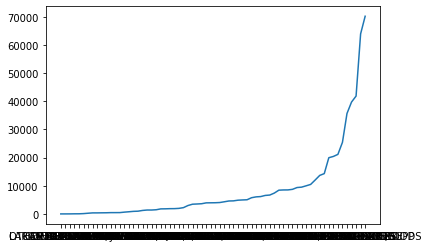

In [55]:
print(df_train_f1.drop('TripType', axis=1).sum(axis=0).sort_values())
plt.plot(df_train_f1.drop('TripType', axis=1).sum(axis=0).sort_values())

At this point, you could manually do some experiments to see if there are categories (like SEASONAL > 0) where all the TripTypes are the same. In this case, you could (and should) set a manual rule.

**Question**: For visits that involved buying seasonal items, what were the TripTypes?

In [56]:
df_train_f1[df_train_f1['SEASONAL']>0].shape

(21, 69)

In [57]:
df_train_f1['SEASONAL'].sum()

22.0

In [58]:
df_train_f1[df_train_f1['SEASONAL']>0]['TripType'].value_counts()

44    4
42    4
40    3
25    2
15    2
9     1
12    1
41    1
39    1
6     1
5     1
Name: TripType, dtype: int64

In [59]:
df_train_f1[df_train_f1['OTHER DEPARTMENTS']>0]['TripType'].value_counts()

999    19
38      3
6       1
15      1
9       1
Name: TripType, dtype: int64

In [60]:
df_train_f1[df_train_f1['CONCEPT STORES']>0]['TripType'].value_counts()

999    27
3       2
Name: TripType, dtype: int64

**Question**: Repeat this exercise for each department to see if there's any department which if it is present, results in > 95% of the trip types being of the same type

In [61]:
df_train_f1[df_train_f1['CONCEPT STORES']>0]['TripType'].value_counts().sum()

29

In [62]:
for col in df_train_f1.drop('TripType', axis=1).columns:
    counts = df_train_f1[df_train_f1[col]>0]['TripType'].value_counts()
    if counts.iloc[0] / counts.sum() > 0.95:
        print(col)

LARGE HOUSEHOLD GOODS
OPTICAL - LENSES


In [63]:
df_train_f1[df_train_f1['OPTICAL - LENSES']>0]['TripType'].value_counts()

5    44
Name: TripType, dtype: int64

In [64]:
df_train_f1[df_train_f1['LARGE HOUSEHOLD GOODS']>0]['TripType'].value_counts()

3      63
999     1
Name: TripType, dtype: int64

In this case, one could create a rule that predicts trip type 5 for any trip that had a visit to "OPTICAL - LENSES" or "LARGE HOUSEHOLD GOODS" except that combined they affect only ~100 visits.

**Question**: Look at how many distinct number of items were bought for each visit number.

In [65]:
n_distinct = df.groupby('VisitNumber').count()['TripType']

[  1   1   1 ... 113 151 209]


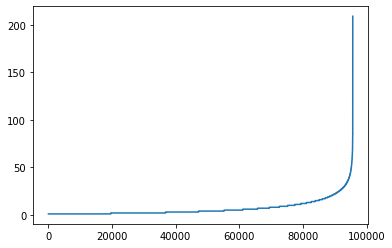

In [66]:
print(np.sort(n_distinct))
plt.plot(np.sort(n_distinct))

Let's zoom in at both ends of the plot.

**Question**: Explore the data at for very low and very high distinct items.

In [67]:
df_train[df_train['VisitNumber'].isin(n_distinct[n_distinct==1].index)].head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
88,8,29,Friday,1.200001e+09,1,DSD GROCERY,9205.0
89,9,30,Friday,9.933894e+09,1,LADIESWEAR,1180.0
92,8,32,Friday,3.400000e+09,1,IMPULSE MERCHANDISE,100.0
99,8,42,Friday,4.000049e+09,1,IMPULSE MERCHANDISE,115.0


In [68]:
df_train[df_train['VisitNumber'].isin(n_distinct[n_distinct==1].index)]['Weekday'].value_counts()

Friday       2720
Saturday     2679
Sunday       2517
Monday       2170
Wednesday    1943
Tuesday      1869
Thursday     1813
Name: Weekday, dtype: int64

In [69]:
df_train[df_train['VisitNumber'].isin(n_distinct[n_distinct==1].index)]['DepartmentDescription'].value_counts()

FINANCIAL SERVICES     1560
DSD GROCERY            1110
IMPULSE MERCHANDISE     878
PHARMACY OTC            820
PHARMACY RX             663
                       ... 
OTHER DEPARTMENTS        18
LADIES SOCKS             18
SHEER HOSIERY            13
OPTICAL - LENSES         12
SEAFOOD                  10
Name: DepartmentDescription, Length: 66, dtype: int64

In [70]:
df_train[df_train['VisitNumber'].isin(n_distinct[n_distinct==1].index)]['TripType'].value_counts()

8      4022
9      3639
999    3120
5      1329
7       940
3       681
6       414
22      213
32      200
24      177
4       124
31      117
30      112
19       95
27       57
23       49
35       48
28       47
26       41
15       33
29       33
18       32
39       30
20       29
36       29
21       19
34       15
33       14
25       13
37       13
38       11
42       10
12        4
41        1
Name: TripType, dtype: int64

**General point**: This kind of manual exploration guided by a series of questions is one way of looking at a dataset. There's a second way that we'll explore on day 3 where a model is built as fast as possible and inspected to identify patterns.

Machine learning techniques are not just tools for predicting values but can also be used to deeply understand your data.

In [71]:
n_distinct[n_distinct > 150].index

Int64Index([72439, 88011], dtype='int64', name='VisitNumber')

In [72]:
df_train[df_train['VisitNumber'].isin(n_distinct[n_distinct > 150].index)].head()
#.head() so the whole table doesn't get displayed in github but do take a look at the full table

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
244440,24,72439,Tuesday,8.861669e+10,1,BOYS WEAR,1025.0
244441,24,72439,Tuesday,7.602631e+09,2,COOK AND DINE,2067.0
244442,24,72439,Tuesday,7.214063e+09,1,PERSONAL CARE,3090.0
244443,24,72439,Tuesday,4.393559e+09,2,MENS WEAR,5542.0
244444,24,72439,Tuesday,4.747559e+09,1,CELEBRATION,5507.0


At this stage, we are really ready to just build the model.

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
model = LogisticRegression()
model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

/home/sanjay/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sanjay/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

As a coarse measure, let's look at accuracy = % of examples predicted correctly. We won't look at the test set during this process. It is set aside and should have no influence on our model selection process.

In [75]:
train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

In [76]:
train_class_pred[0:10]

array([999,   9,  26,   8,   8,   8,  39,  21,   8,  25])

In [77]:
train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

Train Acc = 0.6136479441853173
Val   Acc = 0.6183756663530887


**Good news**: The accuracy metrics are very similar across train and validation. This means our model is not overfitting or memorizing the train set. It is (hopefully) possible to increase the accuracy by changing the parameters of the model, using different features, or maybe using a different modeling technique.

**Evaluating accuracy**: Whenever there's a metric that evaluates a model, one should ask the question - what would the metric be if we had a very simple or dumb model?

Let's look at two examples here.

In [78]:
df_train_f1['TripType'].value_counts()

8      9717
39     7864
9      7643
999    6737
40     4865
7      4558
5      3642
3      3001
25     2979
36     2398
38     2239
37     2185
24     2075
35     1621
32     1562
42     1512
6      1044
33     1017
44      969
15      870
30      868
22      752
43      740
27      702
34      532
21      510
20      510
31      470
41      469
18      441
26      411
28      392
29      351
4       300
19      296
12      192
23      101
14        4
Name: TripType, dtype: int64

What if we predicted every TripType to be the dominant class - TripType = 8 (with 9717 examples). Then we would get 9717 correct predictions and the rest would be wrong to give an accuracy of:

$$\frac{9717}{76539} \approx 12.7\% $$

much worse than the 60% we see from our model.

What if we randomly assigned a trip type to each visit? We have 38 unique labels and it would give us a probability of 

$$\frac{1}{38} \approx 2.6\%$$

guessing the right label. In other words, this would give us an even worse accuracy.

But, all the trip types should not have the same probability of being guessed since they are unevenly distributed. Let's do a simple simulation for this.

In [79]:
counts = df_train_f1['TripType'].value_counts()
probs_visit = counts.index
probs_values = counts.values

probs_values = probs_values / np.sum(probs_values)
assert(probs_values.sum()==1)

In [80]:
random_pred_train = np.random.choice(probs_visit, size=df_train_f1.shape[0], p=probs_values)

In [81]:
print(f'random train acc = {np.sum(random_pred_train==df_train_f1["TripType"].tolist())/df_train_f1.shape[0]}')

random train acc = 0.062739257110754


So a random strategy would give us an accuracy of ~6.4%. So our model is indeed much better than a silly model.

Of course, what we really care about is the logarithmic loss below:

$$-\frac{1}{N} \Sigma_{i=1}^N \Sigma_{j=1}^M y_{ij} \log(p_{ij})$$

where:

$N$ = number of rows

$M$ = number of trip types

$
y_{ij} =
\begin{cases}
1,  \text{ if ith row has trip type j}\\
0,   \text{ otherwise} \\
\end{cases}$

$p_{ij} = \text{probability of the ith row being of trip-type j}$

Note that $y_{ij}$ are labels and $p_{ij}$ are your model's predictions. Also, note that for a fixed row $i$, only one of $y_{ij} = 1$ and the rest are 0. So the contribution of that row to the cost is $-\log(p_{ij})$. In other words, if the model very confidently predicts the correct class, $p_{ij} \approx 1 \implies -\log(p_{ij}) \approx 0$ i.e. there's no contribution to the cost. On the other hand, if the model predicts the correct class' probability with very low confidence i.e. $p_{ij}\approx 0 \implies -log(p_{ij}) \approx \infty$ so we get a very high loss.

So even one bad prediction can really throw off your loss function and give a large value.

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/overview/evaluation

To evaluate this, we can use an in-built sklearn implementation but we need the probability of a visit to belong to each trip type.

**Question**: look at the documentation for sklearn.linear_model.LogisticRegression and see if it exposes the class probabilities for each prediction.

In [123]:
model.predict_proba(df_train_f1.drop('TripType', axis=1)).shape
#one column for each class

(76539, 38)

In [124]:
from sklearn.metrics import log_loss

In [132]:
model.predict_proba(df_val_f1.drop('TripType', axis=1))

array([[2.72278946e-03, 2.03374409e-03, 2.40443069e-03, ...,
        6.05622367e-03, 3.11965647e-03, 8.60140275e-06],
       [7.07933484e-03, 6.76231457e-03, 2.43139663e-02, ...,
        8.14511402e-03, 4.65079313e-03, 1.17789083e-01],
       [8.87184297e-07, 1.61540167e-06, 7.00859159e-05, ...,
        1.05132502e-03, 5.30001976e-03, 2.14041600e-06],
       ...,
       [7.07933484e-03, 6.76231457e-03, 2.43139663e-02, ...,
        8.14511402e-03, 4.65079313e-03, 1.17789083e-01],
       [2.13111534e-03, 4.38457812e-03, 9.18701684e-03, ...,
        1.62717825e-02, 8.29148518e-03, 2.15099125e-02],
       [5.68210715e-03, 3.44066883e-03, 6.10251129e-03, ...,
        1.34562650e-02, 1.12285781e-02, 1.48914724e-02]])

In [135]:
model.classes_

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

In [136]:
train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

In [137]:
print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train loss = 1.4777506943370753
Val   loss = 1.4738018786470404


At least we are not overfitting. If we were to trust the validation loss and extrapolate to the public leaderboard - https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/leaderboard

we would be at position 559 / 1046. But maybe we don't care about the competition. In terms of accuracy, maybe your business is happy with a ~62.% accuracy. Are there other metrics we can look at to understand what this model is doing?

The first quantity we will look at is the confusion matrix. An example will make it clear

In [139]:
from sklearn.metrics import confusion_matrix

In [153]:
cmat = confusion_matrix(df_val_f1['TripType'].tolist(), model.predict(df_val_f1.drop('TripType', axis=1)).tolist())
print(cmat)

[[286   0   1 ...   0   0   0]
 [  0   0   6 ...   0   0   0]
 [  1   0 341 ...   0   0   0]
 ...
 [  1   0   5 ...   0   0   0]
 [  0   0   3 ...   0   3   0]
 [ 62   0   4 ...   0   0 669]]


TBD - confusion matrix

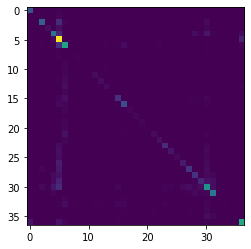

In [160]:
fig, ax = plt.subplots()
ax.imshow(cmat)

ax.set_xticks(np.arange())
ax.set_yticks(np.arange())
              
ax.set_xticklabels()
ax.set_yticklabels()



In [143]:
confusion_matrix?

In [145]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
confusion_matrix(y_true, y_pred) #, labels=["ant", "bird", "cat"])

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

Model introspection - confusion matrix, precision/recall, weights

(DONE) Changing loss

Various featurizations

Example of grid search

### Changing the loss used by Logistic Regression

At this stage, you should have a reasonable question. Everything we saw about logistic regression referred to the binary classification problem i.e. there were two classes - 0 and 1 and we were trying to classify objects/rows into these two classes. But here we have 38 classes and logistic regression still worked. 

**Question**: look at the documentation for sklearn.linear_model.LogisticRegression and see if you can discover how the model accounts for multiple classes.

LogisticRegression takes a parameter called "multi-class". By default, it takes the value "ovr". (See _check_multi_class in sklearn/linear_model/logistic.py).

"ovr" (one-vs-rest) turns a problem with N classes into N binary classification problems. More concretely, if the N classes are $1, 2, \ldots, N$, then N models will be built. The first one will label class 1 as 1 and everything else as 0. The second model will label class 2 as 1 and everything as 0 and so on. Each model will then be called during inference to predict a score. These scores are then normalized (divide by sum of scores).

"multinomial" solves a fundamentally different problem. It optimizes for the loss that is exactly our loss above. In other words, (TBD)

So let's try repeating the procedure above but with "multinormial"

In [361]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(df_train_f1.drop('TripType', axis=1), df_train_f1['TripType'])

/home/sanjay/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [362]:
train_class_pred = model.predict(df_train_f1.drop('TripType', axis=1))
val_class_pred = model.predict(df_val_f1.drop('TripType', axis=1))

In [363]:
train_acc = np.sum(train_class_pred==df_train_f1['TripType'].tolist()) / df_train_f1.shape[0]
val_acc = np.sum(val_class_pred==df_val_f1['TripType'].tolist()) / df_val_f1.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

Train Acc = 0.6626556396085655
Val   Acc = 0.668339082261942


**Note**: Our accuracy jumped from 61-62% to ~66%. This is a significant improvement just by changing the loss function. In particular, this is a general theme in machine learning. All machine learning problems can be rephrased as numerical optimization problems. What you optimize has a huge impact on performance. There's a translation from business/research-level metrics to a function that is relatively easy to optimize but also captures the salient features of the business/research-level metric.

In [364]:
train_log_loss = log_loss(df_train_f1['TripType'], model.predict_proba(df_train_f1.drop('TripType', axis=1)), eps=1e-15)
val_log_loss = log_loss(df_val_f1['TripType'], model.predict_proba(df_val_f1.drop('TripType', axis=1)), eps=1e-15, labels=model.classes_)

In [365]:
print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train loss = 1.1856265142547768
Val   loss = 1.180931437417699


As expected, directly optimizing the multinomial loss results in a significantly lower value (compared to ~1.47 earlier with ovr). A pessimistic value of 1.185 would place us at 490 / 1046 on the leaderboard.

### Changing featurization strategies

The most obvious feature we can include is day of week. Since the 7 days are given as strings, how should we encode them? One option is to map each day to an integer.

Monday -> 0

Tuesday -> 1

Wednesday -> 2

and so on.

**Question**: Do you think is a reasonable idea? Why or why not?

Recall that we are working with a linear model that makes predictions:

$$p = \sigma(w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n)$$

Suppose, the last feature $x_n$ is the weekday and we keep all the other features constant. Also, suppose $w_n > 0$.

Then,

$$p_\text{Wednesday} > p_\text{Monday}$$

where $p_\text{Wednesday} = \sigma(w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n * 2)$ and $p_\text{Monday} = \sigma(w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n * 0)$

In other words, by the sheer act of encoding the days in a certain way, we have imposed an order on our predictions. We could have chosen any of 7! (factorial) permutations for the assignment of integers to the days. Each would impose its own order:

Monday > Thursday > Sunday > Tuesday > Wednesday > Friday > Saturday

Clearly, this is something we would like to learn. Moreover, when you move from one day to the next, the argument of the sigmoid function always increments by a constant that is $w_n$. Lastly, it's also probably not true that this relationship always holds irrespective of the values $x_1, \ldots, x_{n-1}$ take. For example, maybe the sale of beer on a wednesday makes it more likely that the trip type is 1 as compared to a monday. But maybe the sale of icecream on a wednesday makes it less likely that the trip type is 1 as compared to a monday. In other words, for beer, switching from monday to wednesday should increase the probability of being trip type 1 but for icecream, switching from monday to wednesday should decrease the probability of being trip type 1.

So, we need to encode these days in a different way. The most usual way is to assign a new column for every unique value. So there'll be one column for Mondays which is 1 when the day is Monday and 0 otherwise. This is called **one-hot encoding**.

In [368]:
df_train['Weekday'].head(10)

0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
5    Friday
6    Friday
7    Friday
8    Friday
9    Friday
Name: Weekday, dtype: object

In [370]:
pd.get_dummies(df_train['Weekday']).head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


What are the implications of this encoding. Again, pretend that $x_1, \ldots, x_{n-1}$ are kept constant. Then the prediction is:

$p = \sigma(C + w_{n,\text{Monday}} x_\text{Monday} + w_{n,\text{Tuesday}} x_\text{Tuesday} + \ldots + w_{n,\text{Sunday}} x_\text{Sunday})$

where there's a new weight for each possible day and each feature $x_\text{day}$ can only be 0 or 1 and exactly one of these will be 1.

In essence, we have a different intercept $w_0$ for each day:

$w_0 + w_{n, \text{Monday}}$ for Monday

$w_0 + w_{n, \text{Tuesday}}$ for Tuesday

and so on. Then the model can learn the appropriate weights and decide which ordering (and what differences between two consecutive weights) are most appropriate. We still have the problem that if everything else is kept constant, there's a fixed ordering between days. That's because linear models don't automatically take **interactions** between features into account and have no way of discovering such structure unless we explicitly pass a feature that models the interaction (for example $x_1 * x_{n, \text{Monday}})$.


In [389]:
df_train_f2 = pd.concat([df_train_f1, 
                         pd.get_dummies(df_train[['VisitNumber', 'Weekday']].set_index('VisitNumber'),
                                        prefix='Weekday')], 
                         axis=1)

In [393]:
df_val_f2 = pd.concat([df_val_f1, 
                       pd.get_dummies(df_val[['VisitNumber', 'Weekday']].set_index('VisitNumber'),
                                      prefix='Weekday')], 
                       axis=1)
df_val_f2 = df_val_f2[df_train_f2.columns] #ensure column order is the same

KeyError: "['Weekday_Sunday', 'Weekday_Saturday'] not in index"

In [394]:
df_test_f2 = pd.concat([df_test_f1, 
                        pd.get_dummies(df_test[['VisitNumber', 'Weekday']].set_index('VisitNumber'),
                                       prefix='Weekday')], 
                         axis=1)
df_test_f2 = df_test_f2[df_train_f2.columns]

KeyError: "['Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Monday'] not in index"

In [392]:
df_train_f2.head()

,TripType,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
7,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
7,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
8,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0
8,26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,0


In [383]:
pd.get_dummies(df_train['Weekday'])

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
516623,0,1,0,0,0,0,0
516624,0,1,0,0,0,0,0
516625,0,1,0,0,0,0,0
516626,0,1,0,0,0,0,0


Till now, we have been using df_train_f1 for model training. Each row represents a trip and we have the counts of various items by department. Let's start tweaking this representation now.

The first thing we'll try is the following:

* Normalize the distribution - so the entries will now be % of items bought in each department and we'll have a separate column for the total items bought. We'll call this "f2".

In [170]:
df_train_f1.iloc[0]

TripType                 999.0
-1                         0.0
1-HR PHOTO                 0.0
ACCESSORIES                0.0
AUTOMOTIVE                 0.0
                         ...  
SLEEPWEAR/FOUNDATIONS      0.0
SPORTING GOODS             0.0
SWIMWEAR/OUTERWEAR         0.0
TOYS                       0.0
WIRELESS                   0.0
Name: 5, Length: 69, dtype: float64

In [171]:
df_train_f1.columns

Index(['TripType', '-1', '1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
       'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
       'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES',
       'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD',
       'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR', 'HOME MANAGEMENT',
       'HORTICULTURE AND ACCESS', 'HOUSEHOLD CHEMICALS/SUPP',
       'HOUSEHOLD PAPER GOODS', 'IMPULSE MERCHANDISE', 'INFANT APPAREL',
       'INFANT CONSUMABLE HARDLINES', 'JEWELRY AND SUNGLASSES', 'LADIES SOCKS',
       'LADIESWEAR', 'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN',
       'LIQUOR,WINE,BEER', 'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING',
       'MENS WEAR', 'MENSWEAR', 'OFFICE SUPPLIES', 'OPTICAL - FRAMES',
       'OPTICAL - LENSES', 'OTH

In [172]:
f1_feature_cols = df_train_f1.drop('TripType', axis=1).columns

In [218]:
#check that every entry in f1_feature_cols is actually a department description

set(f1_feature_cols).symmetric_difference(df_train['DepartmentDescription'].unique())

set()

In [219]:
#get counts
total_train_counts = df_train_f1[f1_feature_cols].sum(axis=1)

In [225]:
#paranoid people check columns by name
for col in df_train_f1[f1_feature_cols].columns: print(col)

-1
1-HR PHOTO
ACCESSORIES
AUTOMOTIVE
BAKERY
BATH AND SHOWER
BEAUTY
BEDDING
BOOKS AND MAGAZINES
BOYS WEAR
BRAS & SHAPEWEAR
CAMERAS AND SUPPLIES
CANDY, TOBACCO, COOKIES
CELEBRATION
COMM BREAD
CONCEPT STORES
COOK AND DINE
DAIRY
DSD GROCERY
ELECTRONICS
FABRICS AND CRAFTS
FINANCIAL SERVICES
FROZEN FOODS
FURNITURE
GIRLS WEAR, 4-6X  AND 7-14
GROCERY DRY GOODS
HARDWARE
HOME DECOR
HOME MANAGEMENT
HORTICULTURE AND ACCESS
HOUSEHOLD CHEMICALS/SUPP
HOUSEHOLD PAPER GOODS
IMPULSE MERCHANDISE
INFANT APPAREL
INFANT CONSUMABLE HARDLINES
JEWELRY AND SUNGLASSES
LADIES SOCKS
LADIESWEAR
LARGE HOUSEHOLD GOODS
LAWN AND GARDEN
LIQUOR,WINE,BEER
MEAT - FRESH & FROZEN
MEDIA AND GAMING
MENS WEAR
MENSWEAR
OFFICE SUPPLIES
OPTICAL - FRAMES
OPTICAL - LENSES
OTHER DEPARTMENTS
PAINT AND ACCESSORIES
PERSONAL CARE
PETS AND SUPPLIES
PHARMACY OTC
PHARMACY RX
PLAYERS AND ELECTRONICS
PLUS AND MATERNITY
PRE PACKED DELI
PRODUCE
SEAFOOD
SEASONAL
SERVICE DELI
SHEER HOSIERY
SHOES
SLEEPWEAR/FOUNDATIONS
SPORTING GOODS
SWIMWEAR/OUTER

Let's do a few checks to ensure our total counts look reasonable

In [230]:
print(total_train_counts.min())

-52.0


That doesn't look right. Is there a visit with 52 returns?!

In [232]:
total_train_counts[total_train_counts==total_train_counts.min()]

VisitNumber
27471   -52.0
dtype: float64

In [236]:
df_train_f1.loc[27471].sort_values()

PHARMACY OTC               -17.0
COOK AND DINE              -14.0
GROCERY DRY GOODS          -10.0
LAWN AND GARDEN             -3.0
IMPULSE MERCHANDISE         -2.0
                           ...  
HORTICULTURE AND ACCESS      0.0
HOUSEHOLD PAPER GOODS        0.0
TOYS                         0.0
JEWELRY AND SUNGLASSES       0.0
TripType                   999.0
Name: 27471, Length: 69, dtype: float64

In [238]:
df_train[df_train['VisitNumber']==27471]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
95346,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95347,999,27471,Tuesday,7.644091e+09,-1,COOK AND DINE,3609.0
95348,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95349,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95350,999,27471,Tuesday,4.704666e+09,-1,PHARMACY OTC,713.0
95351,999,27471,Tuesday,7.931900e+10,-1,PHARMACY OTC,713.0
95352,999,27471,Tuesday,7.447102e+09,-2,GROCERY DRY GOODS,3302.0
95353,999,27471,Tuesday,7.128786e+09,-1,COOK AND DINE,378.0
95354,999,27471,Tuesday,2.120057e+09,-1,HOUSEHOLD CHEMICALS/SUPP,9530.0
95355,999,27471,Tuesday,1.117265e+09,-1,COOK AND DINE,514.0


In [240]:
df_train[df_train['VisitNumber']==27471].groupby('DepartmentDescription').sum()['ScanCount']

DepartmentDescription
ACCESSORIES                 -1
COOK AND DINE              -14
GROCERY DRY GOODS          -10
HOUSEHOLD CHEMICALS/SUPP    -2
IMPULSE MERCHANDISE         -2
LADIESWEAR                  -1
LAWN AND GARDEN             -3
PERSONAL CARE               -1
PHARMACY OTC               -17
SWIMWEAR/OUTERWEAR          -1
Name: ScanCount, dtype: int64

Well actually there **IS** such a trip

In [241]:
df_train_f2 = df_train_f1[f1_feature_cols].apply(lambda x: x.abs() / x.sum(), axis=1)

Whenever we do a division, it's good to check if there are any divisions by 0.

In [244]:
df_train_f1[df_train_f1[f1_feature_cols].sum(axis=1)==0].shape

(1410, 69)

Wow! we have 1410 trips where the total count of all items bought is 0. This means one of two things - either nothing was bought (then why is there a trip in our data) or what's more likely is that these trips had some returns too. Let's check

In [252]:
total0_visits = df_train_f1[df_train_f1[f1_feature_cols].sum(axis=1)==0].index

In [274]:
df_train[df_train['VisitNumber'].isin(total0_visits)].groupby('VisitNumber').agg({'ScanCount': lambda x: np.sum(np.abs(x))}).sort_values(by='ScanCount')['ScanCount'].value_counts()

2     1049
4      211
6       71
8       41
10      13
12       8
16       6
18       3
30       2
22       2
20       2
14       2
Name: ScanCount, dtype: int64

Let's look at the trip types for these visits.

In [291]:
df_train[df_train['VisitNumber'].isin(total0_visits)][['VisitNumber', 'TripType']].drop_duplicates()['TripType'].value_counts()

999    1409
8         1
Name: TripType, dtype: int64

That's very interesting. Are we to infer that if there's a single return, then the trip is mostly like "999" (other)

In [280]:
df_train[df_train['ScanCount']<0]['ScanCount'].unique()

array([ -1,  -2,  -3,  -5,  -4,  -6, -12,  -7,  -9])

In [292]:
df_train[df_train['ScanCount']<0][['TripType', 'VisitNumber']].drop_duplicates()['TripType'].value_counts()

999    5097
40      739
39      490
37      231
9       224
8       213
25      206
7       157
38      149
36      139
24      123
42      123
44      102
32       85
5        82
35       70
33       67
22       45
15       44
41       44
43       43
27       41
20       37
6        36
3        36
30       31
34       27
18       27
21       26
31       23
26       21
28       19
29       18
19       15
12       13
23        6
4         6
14        1
Name: TripType, dtype: int64

In [295]:
len(df_train[df_train['ScanCount']<0]['VisitNumber'].unique())

8856

**Point 1**: If we look at all the trips that have even one single return, then the vast majority are of type 999. The actual fraction is: 

$$\frac{5097}{8856} \approx 57\%$$

**Point 2**: If we look at all the trips where **the total sum of items = 0** (this is a strict subset of the visits considered in point 1), then 

$$\frac{1409}{1410} \approx 100\%$$

of the trips are of type 999!

There are two ways to proceed from here. We could modify our procedure when we normalize the counts to something like:

x / x.sum() to x / (x.sum() + $\epsilon$)

where $\epsilon$ is some small number, say $10^{-10}$.

Another way would be to create a rule. Always check the total "ScanCount" of a trip. If it's equal to 0, assign its trip type to 999, otherwise use our model. We also have to remove all such rows from our dataset.

I am also curious to see what actually causes one of the rows to be assigned the trip type 8. Let's inspect those two rows to see if something pops out.

In [288]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==8)]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
321206,8,96445,Saturday,9506.0,1,DSD GROCERY,9225.0
321207,8,96445,Saturday,9506.0,-1,DSD GROCERY,9225.0


The only reasonable guess is that there's something in the type of product bought.

In [302]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==999)]['DepartmentDescription'].value_counts()

IMPULSE MERCHANDISE      401
MENS WEAR                202
DSD GROCERY              176
FINANCIAL SERVICES       152
PERSONAL CARE            147
                        ... 
FURNITURE                  7
MENSWEAR                   6
SHEER HOSIERY              5
SEAFOOD                    4
MEAT - FRESH & FROZEN      2
Name: DepartmentDescription, Length: 62, dtype: int64

We see "DSD Grocery" here. Maybe it's the FinelineNumber

In [305]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==999)]['FinelineNumber'].value_counts().loc[9225]

4

It's quite rare but still present. Maybe the Upc?

In [307]:
df_train[(df_train['VisitNumber'].isin(total0_visits)) & (df_train['TripType']==999)]['Upc'].value_counts().loc[9506]

3

Even the product Upc shows up. At this stage, I wouldn't manually spend more effort trying to understand this. Well I would, just out of curiosity, but let's move on to more productive tasks. Instead of defining a rule, I am going to use the $\epsilon$ trick. If this was a kaggle competition, I would try both and see what performed better. My hunch is that the rule would actually perform better. In real-life, I would go to the SME (subject-matter expert) and try to understand exactly what's going on. It's entirely possible that this rule is something real and we should code it up. On the other hand, if the rule is fluid, I would prefer my model to discover it instead of manually codifying it.

In [311]:
EPS = 1e-10

In [312]:
df_train_f2 = df_train_f1[f1_feature_cols].apply(lambda x: x.abs() / (x.sum() + EPS), axis=1)

In [313]:
df_train_f2['TripType'] = df_train_f1['TripType']
df_train_f2['TotalCounts'] = total_train_counts

In [314]:
df_train_f2.head()

,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TripType,TotalCounts
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,999,-1.0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,30,2.0
8,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,28.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,3.0
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,3.0


In [322]:
#repeat for val and test
df_val_f2 = df_val_f1[f1_feature_cols].apply(lambda x: x.abs() / (x.sum() + EPS), axis=1)
df_test_f2 = df_test_f1[f1_feature_cols].apply(lambda x: x.abs() / (x.sum() + EPS), axis=1)

In [323]:
total_val_counts = df_val_f1[f1_feature_cols].sum(axis=1)
df_val_f2['TripType'] = df_val_f1['TripType']
df_val_f2['TotalCounts'] = total_val_counts

In [334]:
total_test_counts = df_test_f1[f1_feature_cols].sum(axis=1)
df_test_f2['TripType'] = df_test_f1['TripType']
df_test_f2['TotalCounts'] = total_test_counts

In [335]:
#test one example
assert(df_train[df_train['VisitNumber']==8]['ScanCount'].sum() == df_train_f2.loc[8]['TotalCounts'])

**Normalization**:

Now for the first time, we have a problem that we didn't quite face before. Most of our columns have values 
between 0-1 but we have one column (TotalCounts) which can be signficantly larger than 1.

It helps to have all the numbers on the same scale for linear models. 

1) It makes the optimization process much easier

2) It makes it possible to compare the effects of various columns. If the columns are on similar scales, we can just compare the coefficients $w_i$ and rank them by the absolute values $|w_i|$.

The usual way of making the scales the same is to do the following transformation:

$$x \rightarrow \frac{x - \text{mean}(x)}{\text{std}(x)}$$

where:

$x$ = array of numbers (one column in our case)

$\text{mean}(x)$ = mean of the numbers

$\text{std}(x)$ = standard deviation of the numbers

Strictly speaking, the scale is decided just by the standard deviation but it is helpful to subtract the mean so that the values are centered around 0.

**Leakage**:

Leakage is a general term for information from the validation set and the test set passing into the training process. We discussed earlier that we should set aside the validation and test set and train just on our training set. But there are still subtle ways in which information can pass from the hold-out (val, test) sets into the train set.

**Why is this bad?** Some information, say from the val set, leaking into your train set might improve your model's performance on the val set. So the process that we rely on to estimate how our model will do in real-life is broken - we are getting better results than we would if we actually used our model on new data.

**What is an example of leakage?** In our example, we need to compute the mean and standard deviation of each column and carry out the procedure. The mean and standard deviation should be computed **just on the train set**. In other words, we should split the data and then calculate the mean and standard deviation. If, by mistake, one computes the mean and standard deviation before splitting, then one has leakage.

**Is this really bad?** Not always. Machine learning algorithms make a fundamental assumption that the (statistical) properties of the train set, the val set, and any future data the model sees, are the same. If they are not, your model's performance will most likely severely degrade. If you build a model to classify apples as sellable and not sellable and suddenly you start showing pictures of strawberries, then your model will not be nearly as performant as it was before. On the other hand, if your hold-out set, your train set and your new data will essentially have the same distributions, then this leakage will have no effect.

**Does this mean the val and test set are essentially non-inputs to my model?** Not quite and this is where one has to be careful. Suppose, you are predicting sentiments on pieces of text. You want to create one column for each unique word and a piece of text is featurized by the counts of each word in that piece of text. This is called bag-of-words. This will usually be a very sparse matrix (just like our case above). Now, it is possible that you'll encounter words in the val or test set that you didn't seen in the train set. You could create a special column for unknown words during training or you could look at all the words including those in val and test and create columns for them. Of course, during training, you never see some of those words and those columns will always be 0 so not really helpful during your training process but this is not technically leakage.

A couple of more realistic examples:

1. Suppose your data consists of time-series (numbers indexed by time - stock prices etc.). You decide to featurize them by choosing some histogram bins and counting the number of entries in your time-series in each bin. Looking at all the data to choose the bins is also not leakage. You can think of this as a continuous (as opposed to discrete) version of the word problem above. Of course, if there are bins that are only occupied by the val or test set, then that column will be completely constant (= 0) during the train set and not very helpful but usually that won't happen.

2. While working with language - say sentiment analysis again, you can completely ignore the labels (positive or negative sentiment) and use all the text to build a language model. A language model is a machine learning model that predicts the next word (or character) given the previous history (these are mostly neural network models today). As long as you don't use the labels somehow, this is a completely reasonable thing to do. The language model then is used to map a piece of text to features which are used to predict the sentiment (at this stage, the labels come back in and we follow the usual practice of splitting into train, val and test).

**Takeaway**: Whenever confronted with an ideological truth, it is useful to probe it to understand when exactly it is true and when it is not. Leakage is a severe problem and one should be very careful about it but being ideological about it can lead one to ignore valuable statistical power that you could gain from other sources (like the language model example above).

**Next step**: We'll use sklearn's in-built scaling module to the standard scaling and then build our model.

In [336]:
from sklearn.preprocessing import StandardScaler

In [337]:
scaler = StandardScaler(with_mean=True, with_std=True)

In [340]:
#separate features and target
df_train_f2_features = df_train_f2.drop('TripType', axis=1)
df_val_f2_features = df_val_f2.drop('TripType', axis=1)
df_test_f2_features = df_test_f2.drop('TripType', axis=1)

In [341]:
df_train_f2_target = df_train_f2['TripType']
df_val_f2_target = df_val_f2['TripType']
df_test_f2_target = df_test_f2['TripType']

In [345]:
df_train_f2_scaled = scaler.fit_transform(df_train_f2_features)
df_val_f2_scaled = scaler.transform(df_val_f2_features)
df_test_f2_scaled = scaler.transform(df_test_f2_features)

#these are not pandas dataframes so re-convent to pd.DataFrame
df_train_f2_scaled = pd.DataFrame(df_train_f2_scaled, columns=df_train_f2_features.columns)
df_val_f2_scaled = pd.DataFrame(df_val_f2_scaled, columns=df_val_f2_features.columns)
df_test_f2_scaled = pd.DataFrame(df_test_f2_scaled, columns=df_test_f2_features.columns)

**Development Note**: As you can see, this style of prototyping in a notebook can be very useful. BUT, it can also get chaotic and hard to maintain after some time. In our opinion, the frictionless way is to work with data science projects is to prototype small pieces in a notebook and move them to stand-alone python modules with generic functions that, for example, train and apply a standard scaler.

In [346]:
df_train_f2_scaled.head()

,-1,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,TotalCounts
0,-0.012522,-0.050135,-0.006261,-0.007229,-0.159703,-0.006466,-0.009037,-0.013526,-0.003615,-0.006261,...,-0.011794,-0.004383,-0.030932,-0.008854,-0.008083,-0.010844,-0.009564,-0.013526,-0.010224,-0.824016
1,-0.012522,-0.050135,-0.006261,-0.007229,-0.159703,-0.006466,-0.009037,-0.013526,-0.003615,-0.006261,...,-0.011794,-0.004383,-0.030932,-0.008854,-0.008083,-0.010844,-0.009564,-0.013526,-0.010224,-0.532778
2,-0.012522,-0.050135,-0.006261,-0.007229,-0.159703,-0.006466,-0.009037,-0.013526,-0.003615,-0.006261,...,-0.011794,-0.004383,-0.030932,-0.008854,-0.008083,-0.010844,-0.009564,-0.013526,-0.010224,1.991281
3,-0.012522,-0.050135,-0.006261,-0.007229,-0.159703,-0.006466,-0.009037,-0.013526,-0.003615,-0.006261,...,-0.011794,-0.004383,-0.030932,-0.008854,-0.008083,-0.010844,-0.009564,-0.013526,-0.010224,-0.435699
4,-0.012522,-0.050135,-0.006261,-0.007229,-0.159703,-0.006466,-0.009037,-0.013526,-0.003615,-0.006261,...,-0.011794,-0.004383,-0.030932,-0.008854,-0.008083,-0.010844,-0.009564,-0.013526,-0.010224,-0.435699


Let's train our model again on this data.

In [357]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=200)

In [360]:
model.fit(df_train_f2_features, df_train_f2_target)

/home/sanjay/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sanjay/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sanjay/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [359]:
train_class_pred = model.predict(df_train_f2_scaled)
val_class_pred = model.predict(df_val_f2_scaled)

train_acc = np.sum(train_class_pred==df_train_f2_target.tolist()) / df_train_f2_scaled.shape[0]
val_acc = np.sum(val_class_pred==df_val_f2_target.tolist()) / df_val_f2_scaled.shape[0]

print(f"Train Acc = {train_acc}")
print(f"Val   Acc = {val_acc}")

train_log_loss = log_loss(df_train_f2_target, model.predict_proba(df_train_f2_scaled), eps=1e-15)
val_log_loss = log_loss(df_val_f2_target, model.predict_proba(df_val_f2_scaled), eps=1e-15, labels=model.classes_)

print(f'Train loss = {train_log_loss}')
print(f'Val   loss = {val_log_loss}')

Train Acc = 0.4168724441134585
Val   Acc = 0.4155952754259433
Train loss = 2.1897843797055327
Val   loss = 2.206755578789828


This is an example where 

I'll end this with a story that is often-repeated. Many elements of this story are probably inaccurate, so I'll make my version up.

Apparently, a government's defense department wanted to classify aerial/satellite pictures as ones containing the images of tanks and one that didn't. They outsourced the work to a contractor who built an amazing model (say accuracy = 95% on the validation set). When the model was actually used in the battlefield, it was atrocious (say accuracy = 52%). On further inspection m